In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving instancenormalization.py to instancenormalization.py


In [ ]:
!pip install tensorflow keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Cycle GAN MODEL

In [ ]:
"""
CycleGAN model

The model uses instance normalization layer:
Normalize the activations of the previous layer at each step,
i.e. applies a transformation that maintains the mean activation
close to 0 and the activation standard deviation close to 1.
Standardizes values on each output feature map rather than across features in a batch. ​

"""

#
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
#from keras.models import Input
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

from instancenormalization import InstanceNormalization

from matplotlib import pyplot

import os

In [ ]:
# discriminator model (70x70 patchGAN)
# C64-C128-C256-C512
# After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.
# The “axis” argument is set to -1 for instance norm. to ensure that features are normalized per feature map.
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt.
    #with a small learning rate and 0.55 beta.
    #The loss for the discriminator is weighted by 46% for each model update.
    #This slows down changes to the discriminator relative to the generator model during training.
		#I tried several loss functions, Mean Squared Error, mean_absolute_error and Binary Cross Entropy
		#and found that mean_absolute_error worked better.
	model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.0014, beta_1=0.55, beta_2=0.999), loss_weights=[0.46])
	# model.compile(loss=['binary_crossentropy', 'mean_absolute_error'], optimizer=Adam(lr=0.0014, beta_1=0.7, beta_2=0.999), loss_weights=[0.2,5])

	return model

In [ ]:
# generator a resnet block to be used in the generator
# residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layers.
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [ ]:
# define the  generator model - encoder-decoder type architecture

#c7s1-k denote a 7×7 Convolution-InstanceNorm-ReLU layer with k filters and stride 1.
#dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2.
# Rk denotes a residual block that contains two 3 × 3 convolutional layers
# uk denotes a 3 × 3 fractional-strided-Convolution InstanceNorm-ReLU layer with k filters and stride 1/2

#The network with 6 residual blocks consists of:
#c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3

#The network with 9 residual blocks consists of:
#c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128, u64,c7s1-3

def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model


In [ ]:
# define a composite model for updating generators by adversarial and cycle loss
#We define a composite model that will be used to train each generator separately.
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# Make the generator of interest trainable as we will be updating these weights.
    #by keeping other models constant.
    #Remember that we use this same function to train both generators,
    #one generator at a time.
	g_model_1.trainable = True
	# mark discriminator and second generator as non-trainable
	d_model.trainable = False
	g_model_2.trainable = False

	# adversarial loss
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity loss
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# cycle loss - forward
	output_f = g_model_2(gen1_out)
	# cycle loss - backward
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)

	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])

  # define the optimizer
	opt = Adam(lr=0.0003, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'],
               loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
# select a batch of random samples, returns images and target
#Remember that for real images the label (y) is 1.
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# generate a batch of images, returns images and targets
# Remember that for fake images the label (y) is 0.
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake images
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# periodically save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# save plot results to folder
# import os
output_folder = '/content/drive/MyDrive/final/*Generated images'
os.makedirs(output_folder, exist_ok=True)

# periodically generate images using the save model and plot input and output images
def summarize_performance(step, g_model, trainX, name, n_samples=1):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])

	# save plot to file
	filename1 = os.path.join(output_folder,'%s_generated_plot_%06d.png' % (name, (step+1)))
	pyplot.savefig(filename1)
	pyplot.close()

In [ ]:
# update image pool for fake images to reduce model oscillation
# update discriminators using a history of generated images
# rather than the ones produced by the latest generators.
# Original paper recommended keeping an image buffer that stores
# the 50 previously created images.

def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

In [ ]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
	# define properties of the training run
	n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fake images
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs

	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples from each domain (A and B)
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples using both B to A and A to B generators.
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)

		# update generator B->A via the composite model
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

        # update generator A->B via the composite model
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

        # summarize performance
        #Since our batch size =1, the number of iterations would be same as the size of our dataset.
        #In one epoch you'd have iterations equal to the number of images.
        #If you have 100 images then 1 epoch would be 100 iterations
		print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance periodically
        #If batch size (total images)=100, performance will be summarized after every 75th iteration.
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
            # #If batch size (total images)=100, model will be saved after
            #every 75th iteration x 5 = 375 iterations.
			save_models(i, g_model_AtoB, g_model_BtoA)


# Dataset Test

In [ ]:
"""
Cycle GAN：plastic flowers

"""
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from matplotlib import pyplot as plt


In [ ]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)


In [ ]:
# dataset path
path = '/content/drive/MyDrive/final/dataset3/'

# load dataset A - plastic (fake)flowers pictures
dataA_all = load_images(path + 'plastic flowers/')
print('Loaded dataA: ', dataA_all.shape)


Loaded dataA:  (400, 256, 256, 3)


In [ ]:
from sklearn.utils import resample
#To get a subset of all images, for faster training during demonstration
dataA = resample(dataA_all,
                 replace=True,
                 n_samples=50,
                 random_state=42)
# load dataset B - Photos
dataB_all = load_images(path + '/flower dataset1/')
print('Loaded dataB: ', dataB_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management.
dataB = resample(dataB_all,
                 replace=True,
                 n_samples=50,
                 random_state=42)

Loaded dataB:  (410, 256, 256, 3)


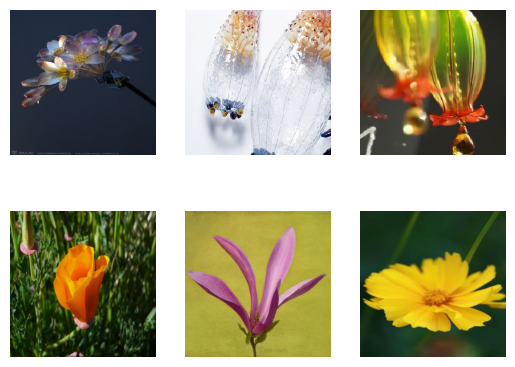

In [ ]:
# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))
plt.show()


In [ ]:
# load image data
data = [dataA, dataB]

print('Loaded', data[0].shape, data[1].shape)


Loaded (50, 256, 256, 3) (50, 256, 256, 3)


In [ ]:
#Preprocess data to change input range to values between -1 and 1
# This is because the generator uses tanh activation in the output layer
#And tanh ranges between -1 and 1
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]_tanh
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
dataset = preprocess_data(data)

In [ ]:
# define input shape based on the loaded dataset
image_shape = data[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
from datetime import datetime
start1 = datetime.now()
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=90)

stop1 = datetime.now()
#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)

1/1 [==============================] - 1s 783ms/step
Iteration>1, dA[0.467,1.952] dB[0.569,1.946] g[20.812,21.087]
1/1 [==============================] - 0s 22ms/step
Iteration>2, dA[2.949,3.945] dB[3.206,1.961] g[27.790,77.338]
1/1 [==============================] - 0s 21ms/step
Iteration>3, dA[2.083,1.338] dB[0.978,1.236] g[35.967,46.732]
1/1 [==============================] - 0s 22ms/step
Iteration>4, dA[0.968,1.284] dB[0.690,0.846] g[19.270,25.959]
1/1 [==============================] - 0s 24ms/step
Iteration>5, dA[0.831,0.930] dB[0.541,0.450] g[17.227,21.617]
1/1 [==============================] - 0s 23ms/step
Iteration>6, dA[0.548,0.868] dB[0.467,0.595] g[19.219,18.746]
1/1 [==============================] - 0s 21ms/step
Iteration>7, dA[0.624,0.368] dB[0.446,0.615] g[15.985,19.050]
1/1 [==============================] - 0s 21ms/step
Iteration>8, dA[0.625,0.420] dB[0.395,0.820] g[13.316,14.712]
1/1 [==============================] - 0s 22ms/step
Iteration>9, dA[0.510,0.534] dB[0.5

>Saved: g_model_AtoB_000250.h5 and g_model_BtoA_000250.h5
1/1 [==============================] - 0s 23ms/step
Iteration>251, dA[0.307,0.316] dB[0.178,0.281] g[7.919,9.089]
1/1 [==============================] - 0s 26ms/step
Iteration>252, dA[0.286,0.339] dB[0.391,0.117] g[8.087,7.872]
1/1 [==============================] - 0s 22ms/step
Iteration>253, dA[0.265,0.349] dB[0.240,0.219] g[8.402,8.225]
1/1 [==============================] - 0s 33ms/step
Iteration>254, dA[0.232,0.259] dB[0.300,0.237] g[8.227,9.296]
1/1 [==============================] - 0s 22ms/step
Iteration>255, dA[0.303,0.335] dB[0.188,0.108] g[10.414,11.601]
1/1 [==============================] - 0s 23ms/step
Iteration>256, dA[0.382,0.281] dB[0.382,0.139] g[5.096,5.155]
1/1 [==============================] - 0s 22ms/step
Iteration>257, dA[0.285,0.352] dB[0.359,0.148] g[10.581,9.178]
1/1 [==============================] - 0s 22ms/step
Iteration>258, dA[0.351,0.253] dB[0.401,0.268] g[8.042,8.899]
1/1 [======================

>Saved: g_model_AtoB_000500.h5 and g_model_BtoA_000500.h5
1/1 [==============================] - 0s 22ms/step
Iteration>501, dA[0.189,0.313] dB[0.159,0.097] g[13.552,12.550]
1/1 [==============================] - 0s 24ms/step
Iteration>502, dA[0.172,0.216] dB[0.129,0.068] g[9.703,9.193]
1/1 [==============================] - 0s 21ms/step
Iteration>503, dA[0.411,0.138] dB[0.193,0.171] g[6.593,8.496]
1/1 [==============================] - 0s 23ms/step
Iteration>504, dA[0.406,0.287] dB[0.228,0.096] g[8.059,7.583]
1/1 [==============================] - 0s 22ms/step
Iteration>505, dA[0.382,0.300] dB[0.226,0.124] g[6.679,7.518]
1/1 [==============================] - 0s 22ms/step
Iteration>506, dA[0.246,0.267] dB[0.318,0.083] g[7.787,6.525]
1/1 [==============================] - 0s 24ms/step
Iteration>507, dA[0.230,0.254] dB[0.167,0.172] g[6.590,5.841]
1/1 [==============================] - 0s 24ms/step
Iteration>508, dA[0.250,0.151] dB[0.137,0.156] g[7.116,6.959]
1/1 [=======================

>Saved: g_model_AtoB_000750.h5 and g_model_BtoA_000750.h5
1/1 [==============================] - 0s 22ms/step
Iteration>751, dA[0.106,0.166] dB[0.360,0.244] g[7.317,8.040]
1/1 [==============================] - 0s 22ms/step
Iteration>752, dA[0.100,0.343] dB[0.054,0.091] g[9.365,9.390]
1/1 [==============================] - 0s 21ms/step
Iteration>753, dA[0.459,0.097] dB[0.251,0.150] g[6.821,6.797]
1/1 [==============================] - 0s 22ms/step
Iteration>754, dA[0.166,0.275] dB[0.105,0.075] g[8.951,9.427]
1/1 [==============================] - 0s 20ms/step
Iteration>755, dA[0.302,0.149] dB[0.133,0.104] g[7.364,7.362]
1/1 [==============================] - 0s 24ms/step
Iteration>756, dA[0.133,0.262] dB[0.116,0.086] g[7.646,8.644]
1/1 [==============================] - 0s 22ms/step
Iteration>757, dA[0.238,0.192] dB[0.070,0.106] g[12.914,11.370]
1/1 [==============================] - 0s 22ms/step
Iteration>758, dA[0.156,0.169] dB[0.270,0.069] g[8.238,8.469]
1/1 [=======================

>Saved: g_model_AtoB_001000.h5 and g_model_BtoA_001000.h5
1/1 [==============================] - 0s 21ms/step
Iteration>1001, dA[0.270,0.172] dB[0.080,0.092] g[7.361,7.198]
1/1 [==============================] - 0s 21ms/step
Iteration>1002, dA[0.154,0.148] dB[0.123,0.143] g[6.508,7.101]
1/1 [==============================] - 0s 24ms/step
Iteration>1003, dA[0.093,0.151] dB[0.102,0.081] g[8.204,8.676]
1/1 [==============================] - 0s 22ms/step
Iteration>1004, dA[0.385,0.083] dB[0.058,0.105] g[7.799,8.236]
1/1 [==============================] - 0s 23ms/step
Iteration>1005, dA[0.230,0.145] dB[0.183,0.114] g[7.147,7.374]
1/1 [==============================] - 0s 22ms/step
Iteration>1006, dA[0.097,0.114] dB[0.099,0.087] g[8.439,10.160]
1/1 [==============================] - 0s 22ms/step
Iteration>1007, dA[0.088,0.142] dB[0.150,0.075] g[7.959,8.766]
1/1 [==============================] - 0s 23ms/step
Iteration>1008, dA[0.353,0.162] dB[0.101,0.177] g[4.599,5.283]
1/1 [================

>Saved: g_model_AtoB_001250.h5 and g_model_BtoA_001250.h5
1/1 [==============================] - 0s 24ms/step
Iteration>1251, dA[0.070,0.119] dB[0.065,0.080] g[8.056,8.504]
1/1 [==============================] - 0s 22ms/step
Iteration>1252, dA[0.304,0.106] dB[0.218,0.049] g[6.684,5.442]
1/1 [==============================] - 0s 21ms/step
Iteration>1253, dA[0.322,0.389] dB[0.082,0.054] g[6.500,5.287]
1/1 [==============================] - 0s 21ms/step
Iteration>1254, dA[0.122,0.285] dB[0.149,0.121] g[5.873,5.525]
1/1 [==============================] - 0s 20ms/step
Iteration>1255, dA[0.375,0.185] dB[0.078,0.309] g[10.897,10.005]
1/1 [==============================] - 0s 23ms/step
Iteration>1256, dA[0.115,0.206] dB[0.098,0.245] g[6.874,7.731]
1/1 [==============================] - 0s 22ms/step
Iteration>1257, dA[0.076,0.077] dB[0.083,0.084] g[7.149,7.990]
1/1 [==============================] - 0s 23ms/step
Iteration>1258, dA[0.072,0.064] dB[0.193,0.129] g[6.398,6.679]
1/1 [===============

>Saved: g_model_AtoB_001500.h5 and g_model_BtoA_001500.h5
1/1 [==============================] - 0s 22ms/step
Iteration>1501, dA[0.093,0.061] dB[0.050,0.050] g[6.731,7.746]
1/1 [==============================] - 0s 22ms/step
Iteration>1502, dA[0.323,0.074] dB[0.371,0.055] g[5.636,6.068]
1/1 [==============================] - 0s 23ms/step
Iteration>1503, dA[0.051,0.144] dB[0.077,0.086] g[7.370,7.682]
1/1 [==============================] - 0s 22ms/step
Iteration>1504, dA[0.084,0.080] dB[0.358,0.096] g[10.023,10.042]
1/1 [==============================] - 0s 22ms/step
Iteration>1505, dA[0.083,0.077] dB[0.039,0.075] g[6.190,9.040]
1/1 [==============================] - 0s 22ms/step
Iteration>1506, dA[0.074,0.061] dB[0.075,0.074] g[8.204,9.730]
1/1 [==============================] - 0s 21ms/step
Iteration>1507, dA[0.080,0.051] dB[0.454,0.116] g[9.069,9.069]
1/1 [==============================] - 0s 22ms/step
Iteration>1508, dA[0.099,0.072] dB[0.397,0.058] g[5.323,5.479]
1/1 [===============

>Saved: g_model_AtoB_001750.h5 and g_model_BtoA_001750.h5
1/1 [==============================] - 0s 21ms/step
Iteration>1751, dA[0.375,0.084] dB[0.034,0.046] g[7.565,8.422]
1/1 [==============================] - 0s 21ms/step
Iteration>1752, dA[0.113,0.107] dB[0.439,0.066] g[8.744,9.570]
1/1 [==============================] - 0s 22ms/step
Iteration>1753, dA[0.046,0.063] dB[0.369,0.083] g[8.107,7.742]
1/1 [==============================] - 0s 22ms/step
Iteration>1754, dA[0.066,0.085] dB[0.078,0.144] g[6.958,8.263]
1/1 [==============================] - 0s 21ms/step
Iteration>1755, dA[0.244,0.071] dB[0.093,0.105] g[5.954,9.745]
1/1 [==============================] - 0s 22ms/step
Iteration>1756, dA[0.073,0.062] dB[0.035,0.035] g[7.036,7.137]
1/1 [==============================] - 0s 21ms/step
Iteration>1757, dA[0.060,0.055] dB[0.050,0.056] g[9.323,9.297]
1/1 [==============================] - 0s 25ms/step
Iteration>1758, dA[0.059,0.081] dB[0.056,0.056] g[7.137,7.768]
1/1 [=================

>Saved: g_model_AtoB_002000.h5 and g_model_BtoA_002000.h5
1/1 [==============================] - 0s 26ms/step
Iteration>2001, dA[0.099,0.110] dB[0.057,0.064] g[6.582,5.541]
1/1 [==============================] - 0s 22ms/step
Iteration>2002, dA[0.075,0.071] dB[0.035,0.064] g[6.396,6.043]
1/1 [==============================] - 0s 24ms/step
Iteration>2003, dA[0.140,0.136] dB[0.309,0.099] g[5.180,5.550]
1/1 [==============================] - 0s 23ms/step
Iteration>2004, dA[0.299,0.334] dB[0.066,0.070] g[11.899,9.252]
1/1 [==============================] - 0s 21ms/step
Iteration>2005, dA[0.108,0.099] dB[0.044,0.087] g[6.706,5.766]
1/1 [==============================] - 0s 22ms/step
Iteration>2006, dA[0.100,0.083] dB[0.372,0.147] g[5.684,6.463]
1/1 [==============================] - 0s 23ms/step
Iteration>2007, dA[0.076,0.234] dB[0.074,0.060] g[9.030,10.305]
1/1 [==============================] - 0s 22ms/step
Iteration>2008, dA[0.264,0.057] dB[0.051,0.342] g[3.619,3.908]
1/1 [===============

>Saved: g_model_AtoB_002250.h5 and g_model_BtoA_002250.h5
1/1 [==============================] - 0s 27ms/step
Iteration>2251, dA[0.059,0.119] dB[0.034,0.074] g[7.204,7.685]
1/1 [==============================] - 0s 23ms/step
Iteration>2252, dA[0.177,0.041] dB[0.037,0.056] g[5.996,7.309]
1/1 [==============================] - 0s 24ms/step
Iteration>2253, dA[0.088,0.062] dB[0.034,0.099] g[5.407,6.224]
1/1 [==============================] - 0s 22ms/step
Iteration>2254, dA[0.223,0.077] dB[0.300,0.211] g[5.769,6.798]
1/1 [==============================] - 0s 25ms/step
Iteration>2255, dA[0.063,0.057] dB[0.068,0.126] g[6.093,6.405]
1/1 [==============================] - 0s 21ms/step
Iteration>2256, dA[0.065,0.046] dB[0.104,0.311] g[5.331,7.307]
1/1 [==============================] - 0s 23ms/step
Iteration>2257, dA[0.074,0.181] dB[0.029,0.070] g[6.106,6.001]
1/1 [==============================] - 0s 22ms/step
Iteration>2258, dA[0.067,0.079] dB[0.063,0.165] g[5.688,6.495]
1/1 [=================

>Saved: g_model_AtoB_002500.h5 and g_model_BtoA_002500.h5
1/1 [==============================] - 0s 23ms/step
Iteration>2501, dA[0.061,0.045] dB[0.041,0.084] g[6.373,6.078]
1/1 [==============================] - 0s 22ms/step
Iteration>2502, dA[0.040,0.096] dB[0.033,0.060] g[5.974,6.880]
1/1 [==============================] - 0s 21ms/step
Iteration>2503, dA[0.068,0.062] dB[0.404,0.080] g[6.376,7.784]
1/1 [==============================] - 0s 21ms/step
Iteration>2504, dA[0.260,0.054] dB[0.058,0.042] g[5.497,6.336]
1/1 [==============================] - 0s 22ms/step
Iteration>2505, dA[0.099,0.048] dB[0.044,0.047] g[5.794,6.383]
1/1 [==============================] - 0s 22ms/step
Iteration>2506, dA[0.054,0.050] dB[0.378,0.110] g[4.421,5.604]
1/1 [==============================] - 0s 21ms/step
Iteration>2507, dA[0.050,0.055] dB[0.042,0.069] g[5.046,6.078]
1/1 [==============================] - 0s 23ms/step
Iteration>2508, dA[0.067,0.055] dB[0.313,0.057] g[5.952,6.406]
1/1 [=================

>Saved: g_model_AtoB_002750.h5 and g_model_BtoA_002750.h5
1/1 [==============================] - 0s 22ms/step
Iteration>2751, dA[0.239,0.053] dB[0.078,0.070] g[4.181,4.554]
1/1 [==============================] - 0s 22ms/step
Iteration>2752, dA[0.113,0.271] dB[0.047,0.034] g[7.377,8.347]
1/1 [==============================] - 0s 20ms/step
Iteration>2753, dA[0.090,0.074] dB[0.063,0.038] g[3.898,4.235]
1/1 [==============================] - 0s 21ms/step
Iteration>2754, dA[0.099,0.053] dB[0.058,0.077] g[6.056,6.428]
1/1 [==============================] - 0s 23ms/step
Iteration>2755, dA[0.076,0.055] dB[0.030,0.047] g[7.282,7.991]
1/1 [==============================] - 0s 22ms/step
Iteration>2756, dA[0.423,0.060] dB[0.037,0.073] g[5.777,5.632]
1/1 [==============================] - 0s 21ms/step
Iteration>2757, dA[0.079,0.069] dB[0.026,0.046] g[6.887,7.488]
1/1 [==============================] - 0s 21ms/step
Iteration>2758, dA[0.122,0.036] dB[0.072,0.058] g[4.731,5.320]
1/1 [=================

>Saved: g_model_AtoB_003000.h5 and g_model_BtoA_003000.h5
1/1 [==============================] - 0s 22ms/step
Iteration>3001, dA[0.063,0.062] dB[0.037,0.033] g[6.596,6.512]
1/1 [==============================] - 0s 21ms/step
Iteration>3002, dA[0.068,0.038] dB[0.321,0.099] g[5.338,7.739]
1/1 [==============================] - 0s 21ms/step
Iteration>3003, dA[0.079,0.045] dB[0.277,0.117] g[6.213,7.582]
1/1 [==============================] - 0s 21ms/step
Iteration>3004, dA[0.040,0.040] dB[0.087,0.108] g[8.093,7.440]
1/1 [==============================] - 0s 23ms/step
Iteration>3005, dA[0.032,0.321] dB[0.045,0.045] g[5.131,5.348]
1/1 [==============================] - 0s 22ms/step
Iteration>3006, dA[0.105,0.060] dB[0.078,0.050] g[4.811,5.797]
1/1 [==============================] - 0s 22ms/step
Iteration>3007, dA[0.084,0.049] dB[0.105,0.074] g[6.321,7.886]
1/1 [==============================] - 0s 22ms/step
Iteration>3008, dA[0.060,0.053] dB[0.050,0.048] g[6.752,7.474]
1/1 [=================

>Saved: g_model_AtoB_003250.h5 and g_model_BtoA_003250.h5
1/1 [==============================] - 0s 21ms/step
Iteration>3251, dA[0.270,0.058] dB[0.015,0.118] g[4.462,7.433]
1/1 [==============================] - 0s 24ms/step
Iteration>3252, dA[0.252,0.161] dB[0.041,0.041] g[6.432,7.851]
1/1 [==============================] - 0s 23ms/step
Iteration>3253, dA[0.111,0.142] dB[0.030,0.047] g[5.796,6.489]
1/1 [==============================] - 0s 22ms/step
Iteration>3254, dA[0.294,0.138] dB[0.066,0.030] g[5.220,5.465]
1/1 [==============================] - 0s 22ms/step
Iteration>3255, dA[0.118,0.155] dB[0.059,0.044] g[4.681,5.631]
1/1 [==============================] - 0s 22ms/step
Iteration>3256, dA[0.049,0.040] dB[0.128,0.056] g[5.728,6.833]
1/1 [==============================] - 0s 21ms/step
Iteration>3257, dA[0.318,0.060] dB[0.254,0.116] g[5.938,6.441]
1/1 [==============================] - 0s 21ms/step
Iteration>3258, dA[0.111,0.093] dB[0.089,0.061] g[6.176,6.448]
1/1 [=================

>Saved: g_model_AtoB_003500.h5 and g_model_BtoA_003500.h5
1/1 [==============================] - 0s 23ms/step
Iteration>3501, dA[0.043,0.110] dB[0.061,0.075] g[8.042,9.802]
1/1 [==============================] - 0s 23ms/step
Iteration>3502, dA[0.085,0.076] dB[0.034,0.139] g[6.646,8.030]
1/1 [==============================] - 0s 23ms/step
Iteration>3503, dA[0.043,0.039] dB[0.156,0.066] g[6.763,8.088]
1/1 [==============================] - 0s 23ms/step
Iteration>3504, dA[0.035,0.046] dB[0.039,0.122] g[5.180,5.285]
1/1 [==============================] - 0s 21ms/step
Iteration>3505, dA[0.032,0.035] dB[0.352,0.069] g[5.705,6.548]
1/1 [==============================] - 0s 26ms/step
Iteration>3506, dA[0.029,0.022] dB[0.043,0.093] g[6.827,8.229]
1/1 [==============================] - 0s 22ms/step
Iteration>3507, dA[0.093,0.044] dB[0.322,0.061] g[5.197,5.530]
1/1 [==============================] - 0s 23ms/step
Iteration>3508, dA[0.388,0.049] dB[0.052,0.082] g[5.121,6.993]
1/1 [=================

>Saved: g_model_AtoB_003750.h5 and g_model_BtoA_003750.h5
1/1 [==============================] - 0s 26ms/step
Iteration>3751, dA[0.100,0.080] dB[0.279,0.063] g[5.392,5.724]
1/1 [==============================] - 0s 24ms/step
Iteration>3752, dA[0.054,0.053] dB[0.033,0.324] g[3.907,5.681]
1/1 [==============================] - 0s 22ms/step
Iteration>3753, dA[0.099,0.076] dB[0.023,0.047] g[5.132,4.755]
1/1 [==============================] - 0s 23ms/step
Iteration>3754, dA[0.052,0.067] dB[0.027,0.093] g[6.405,6.642]
1/1 [==============================] - 0s 23ms/step
Iteration>3755, dA[0.029,0.045] dB[0.030,0.036] g[7.528,8.849]
1/1 [==============================] - 0s 23ms/step
Iteration>3756, dA[0.070,0.052] dB[0.272,0.194] g[5.884,7.406]
1/1 [==============================] - 0s 21ms/step
Iteration>3757, dA[0.034,0.070] dB[0.031,0.052] g[6.927,7.871]
1/1 [==============================] - 0s 21ms/step
Iteration>3758, dA[0.035,0.046] dB[0.013,0.067] g[6.535,6.428]
1/1 [=================

>Saved: g_model_AtoB_004000.h5 and g_model_BtoA_004000.h5
1/1 [==============================] - 0s 23ms/step
Iteration>4001, dA[0.033,0.026] dB[0.043,0.054] g[5.811,6.519]
1/1 [==============================] - 0s 24ms/step
Iteration>4002, dA[0.032,0.035] dB[0.065,0.093] g[5.112,6.352]
1/1 [==============================] - 0s 25ms/step
Iteration>4003, dA[0.172,0.087] dB[0.027,0.163] g[4.411,4.944]
1/1 [==============================] - 0s 22ms/step
Iteration>4004, dA[0.287,0.050] dB[0.067,0.043] g[5.173,5.494]
1/1 [==============================] - 0s 23ms/step
Iteration>4005, dA[0.051,0.092] dB[0.045,0.047] g[5.192,5.957]
1/1 [==============================] - 0s 22ms/step
Iteration>4006, dA[0.068,0.050] dB[0.021,0.072] g[6.038,6.656]
1/1 [==============================] - 0s 22ms/step
Iteration>4007, dA[0.032,0.052] dB[0.041,0.093] g[6.625,7.879]
1/1 [==============================] - 0s 25ms/step
Iteration>4008, dA[0.084,0.030] dB[0.022,0.025] g[5.886,6.372]
1/1 [=================

>Saved: g_model_AtoB_004250.h5 and g_model_BtoA_004250.h5
1/1 [==============================] - 0s 29ms/step
Iteration>4251, dA[0.094,0.036] dB[0.032,0.088] g[5.938,6.288]
1/1 [==============================] - 0s 29ms/step
Iteration>4252, dA[0.052,0.032] dB[0.039,0.075] g[5.747,6.642]
1/1 [==============================] - 0s 28ms/step
Iteration>4253, dA[0.053,0.039] dB[0.037,0.042] g[6.052,6.545]
1/1 [==============================] - 0s 30ms/step
Iteration>4254, dA[0.059,0.022] dB[0.049,0.052] g[5.046,5.064]
1/1 [==============================] - 0s 28ms/step
Iteration>4255, dA[0.056,0.035] dB[0.337,0.044] g[6.237,6.329]
1/1 [==============================] - 0s 34ms/step
Iteration>4256, dA[0.041,0.037] dB[0.046,0.101] g[5.901,7.218]
1/1 [==============================] - 0s 29ms/step
Iteration>4257, dA[0.051,0.037] dB[0.028,0.051] g[6.239,6.951]
1/1 [==============================] - 0s 28ms/step
Iteration>4258, dA[0.070,0.016] dB[0.019,0.050] g[5.499,6.031]
1/1 [=================

>Saved: g_model_AtoB_004500.h5 and g_model_BtoA_004500.h5
Execution time is:  2:43:40.075269


In [ ]:
#save the model results in mydrive
!cp -r /content/g_model_AtoB_003750.h5 /content/drive/MyDrive/final/*Generator_model/
!cp -r /content/g_model_AtoB_004000.h5 /content/drive/MyDrive/final/*Generator_model/
!cp -r /content/g_model_AtoB_004250.h5 /content/drive/MyDrive/final/*Generator_model/
!cp -r /content/g_model_AtoB_004500.h5 /content/drive/MyDrive/final/*Generator_model/

!cp -r /content/g_model_BtoA_003750.h5 /content/drive/MyDrive/final/*Generator_model/
!cp -r /content/g_model_BtoA_004000.h5 /content/drive/MyDrive/final/*Generator_model/
!cp -r /content/g_model_BtoA_004250.h5 /content/drive/MyDrive/final/*Generator_model/
!cp -r /content/g_model_BtoA_004500.h5 /content/drive/MyDrive/final/*Generator_model/


In [ ]:
# Use the saved cyclegan models for image translation
from instancenormalization import InstanceNormalization
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint

In [ ]:
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

In [ ]:
# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

In [ ]:
# load dataset
A_data = resample(dataA_all,
                 replace=True,
                 n_samples=50,
                 random_state=42) # reproducible results

B_data = resample(dataB_all,
                 replace=True,
                 n_samples=50,
                 random_state=42) # reproducible results

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5

In [ ]:
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/drive/MyDrive/final/*Generator_model/g_model_AtoB_004000.h5', cust)
model_BtoA = load_model('/content/drive/MyDrive/final/*Generator_model/g_model_BtoA_004000.h5', cust)

1/1 [==============================] - 0s 23ms/step


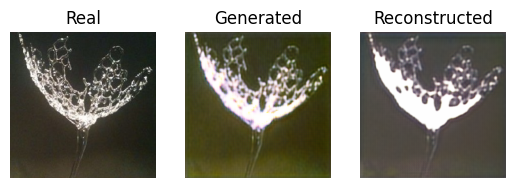

In [ ]:
# plot A->B->A (plastic to flower to plastic)
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)

1/1 [==============================] - 0s 22ms/step


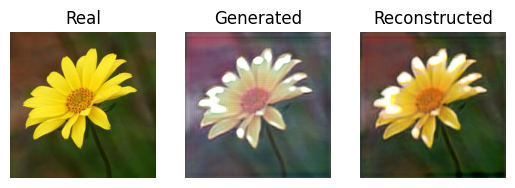

In [ ]:
# plot B->A->B (flower to plastic to flower)
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

# Save_images

In [ ]:
import numpy as np
from PIL import Image

# 调整数组形状或数据类型
B_real = np.squeeze(B_real)
A_generated = np.squeeze(A_generated)
B_reconstructed = np.squeeze(B_reconstructed)

# 将NumPy数组转换为PIL图像
B_real_img = Image.fromarray(np.clip((B_real * 255), 0, 255).astype('uint8'), mode='RGB')
A_generated_img = Image.fromarray(np.clip((A_generated * 255), 0, 255).astype('uint8'), mode='RGB')
B_reconstructed_img = Image.fromarray(np.clip((B_reconstructed * 255), 0, 255).astype('uint8'), mode='RGB')

# Folder path
reconstructed_path='/content/drive/MyDrive/final/*Reconstructed_img/'

# save images
B_real_img.save(reconstructed_path+'B_real.jpg')
A_generated_img.save(reconstructed_path+'A_generated.jpg')
B_reconstructed_img.save(reconstructed_path+'B_reconstructed.jpg')

In [ ]:
import os
import cv2
from PIL import Image

def crop_image(image, x, y, width, height):
    cropped_image = image[y:y+height, x:x+width]
    return cropped_image

folder_path = '/content/drive/MyDrive/final/every_images/train/'  # 文件夹路径
output_folder = "/content/drive/MyDrive/final/new_image"  # 输出文件夹路径
x = 243  # X-coordinate of the top-left corner of the crop area
y = 258  # Y-coordinate of the top-left corner of the crop area
width = 170  # Width of the crop area
height = 170  # Height of the crop area


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Get all the images in the folder
image_files = os.listdir(folder_path)

# Traversing image files
for file_name in image_files:
    # Build the full path to the image file
    image_path = os.path.join(folder_path, file_name)

    # Reading images
    image = cv2.imread(image_path)

    # crop images
    cropped_image = crop_image(image, x, y, width, height)

    # Path to the output image file
    output_path = os.path.join(output_folder, file_name)

    # save
    cv2.imwrite(output_path, cropped_image)
